# 1. Prepare the environment

In [55]:
import sklearn
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cmp


%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]

NumPy 1.26.4

Matplotlib 3.5.2

TensorFlow 2.16.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="DL Resnet50",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "Cow",
    "epochs": 20,
    }
)
'''
# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
'''




In [56]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Load the pretrained model (only the feature extractor)

In [57]:
model_extractor = tf.keras.applications.resnet50.ResNet50(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
model_extractor.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
tf.keras.utils.plot_model(model_extractor, to_file = 'rn_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

# 3. Prepare our dataset

In [59]:
#Load dataset from directory
train = '/Users/Lemon/workspace/DL/HW/Datasets/Train'
val = '/Users/Lemon/workspace/DL/HW/Datasets/Validation'

train_datagen = ImageDataGenerator(preprocessing_function=None)
val_datagen = ImageDataGenerator(preprocessing_function=None)

train_set = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=5,
    class_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    shuffle=True  # Ensure data is shuffled
)


val_set = val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=5,
    class_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    shuffle=True  # Ensure data is shuffled
)


Found 302 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


(5, 224, 224, 3) (5, 4)


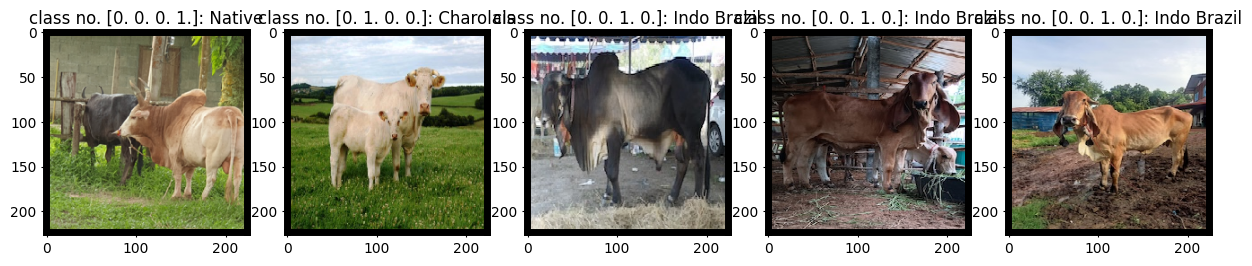

In [60]:
labels = [ 'Brahman', 'Charolais', 'Indo Brazil', 'Native' ]

x_batch, y_batch = next(train_set)
print(x_batch.shape, y_batch.shape)

plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_batch[i]}: {labels[ y_batch[i].argmax() ]}" )
    plt.imshow( x_batch[i].astype(np.uint8))
plt.show()

In [61]:
def preprocess_images(generator):
    for batch in generator:
        images, labels = batch
        preprocessed_images = preprocess_input(images)
        yield preprocessed_images, labels

# Apply preprocessing to the training and validation data generators
train_generator= preprocess_images(train_set)
validation_generator = preprocess_images(val_set)

# Get a batch of preprocessed images to inspect
x_batch_t, y_batch_t = next(train_generator)
xx_batch_v, yy_batch_v = next(validation_generator)

print(x_batch_t.dtype, x_batch_t.shape, np.min(x_batch_t), np.max(x_batch_t))
print(y_batch_t.dtype, y_batch_t.shape, np.min(y_batch_t), np.max(y_batch_t))

print(xx_batch_v.dtype, xx_batch_v.shape, np.min(xx_batch_v), np.max(xx_batch_v))
print(yy_batch_v.dtype, yy_batch_v.shape, np.min(yy_batch_v), np.max(yy_batch_v))


float32 (5, 224, 224, 3) -123.68 151.061
float32 (5, 4) 0.0 1.0
float32 (5, 224, 224, 3) -123.68 151.061
float32 (5, 4) 0.0 1.0


# 4. Prepare for transfer learning and finetuning

1. Add the new classification head
2. Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [62]:
# Access a layer by its 0-based index
a = model_extractor.layers[3]
print( f"Layer {a}: name = {a.name} , trainable = {a.trainable}" )

# Access a layer by its name
b = model_extractor.get_layer('conv5_block3_out')
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )
b.trainable = False       # freeze this layer

Layer <BatchNormalization name=conv1_bn, built=True>: name = conv1_bn , trainable = True
Layer <Activation name=conv5_block3_out, built=True>: name = conv5_block3_out , trainable = True


In [63]:
# Iterate over all layers in the model
for i,layer in enumerate(model_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_layer_3 , trainable = True
Layer 1: name = conv1_pad , trainable = True
Layer 2: name = conv1_conv , trainable = True
Layer 3: name = conv1_bn , trainable = True
Layer 4: name = conv1_relu , trainable = True
Layer 5: name = pool1_pad , trainable = True
Layer 6: name = pool1_pool , trainable = True
Layer 7: name = conv2_block1_1_conv , trainable = True
Layer 8: name = conv2_block1_1_bn , trainable = True
Layer 9: name = conv2_block1_1_relu , trainable = True
Layer 10: name = conv2_block1_2_conv , trainable = True
Layer 11: name = conv2_block1_2_bn , trainable = True
Layer 12: name = conv2_block1_2_relu , trainable = True
Layer 13: name = conv2_block1_0_conv , trainable = True
Layer 14: name = conv2_block1_3_conv , trainable = True
Layer 15: name = conv2_block1_0_bn , trainable = True
Layer 16: name = conv2_block1_3_bn , trainable = True
Layer 17: name = conv2_block1_add , trainable = True
Layer 18: name = conv2_block1_out , trainable = True
Layer 19: name = conv2_b

In [64]:
# Recursively freeze all layers in the model
model_extractor.trainable = False

for i,layer in enumerate(model_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_layer_3 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = conv1_bn , trainable = False
Layer 4: name = conv1_relu , trainable = False
Layer 5: name = pool1_pad , trainable = False
Layer 6: name = pool1_pool , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_conv , trainable = False
Layer 11: name = conv2_block1_2_bn , trainable = False
Layer 12: name = conv2_block1_2_relu , trainable = False
Layer 13: name = conv2_block1_0_conv , trainable = False
Layer 14: name = conv2_block1_3_conv , trainable = False
Layer 15: name = conv2_block1_0_bn , trainable = False
Layer 16: name = conv2_block1_3_bn , trainable = False
Layer 17: name = conv2_block1_add , trainable = False
Layer 18: name = conv2_block1_out , trainable = False
Layer

## 4.2 Add a new classification head

In [65]:
x = model_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x) #512 can be changed to another number before output
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x) #10 is number of the total class

# Construct the main model
model = tf.keras.models.Model(inputs=model_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 75,141,188 (286.64 MB)

 Trainable params: 51,553,476 (196.66 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
tf.keras.utils.plot_model(model, to_file = 'rn_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [67]:
model.compile( loss="categorical_crossentropy" , optimizer="adam", metrics=["acc"] )

In [68]:
#history = model.fit( x_train_vgg, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )
steps_per_epoch = max(1, train_set.samples // train_set.batch_size)
validation_steps = max(1, val_set.samples // val_set.batch_size)


print(f"Total training samples: {train_set.samples}")
print(f"Total validation samples: {val_set.samples}")
print(f'Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}')

ep = 20

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=ep,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Total training samples: 302
Total validation samples: 100
Steps per epoch: 60, Validation steps: 20
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 248ms/step - acc: 0.3042 - loss: 15.2996 - val_acc: 0.4000 - val_loss: 1.6128
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - acc: 0.4499 - loss: 1.6774 - val_acc: 0.4500 - val_loss: 1.2636
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - acc: 0.4512 - loss: 1.4026 - val_acc: 0.6400 - val_loss: 1.2079
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - acc: 0.4791 - loss: 1.2998 - val_acc: 0.6400 - val_loss: 1.0521
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - acc: 0.5303 - loss: 1.2813 - val_acc: 0.6800 - val_loss: 0.9752
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - acc: 0.4751 - loss: 1.3512 - val_acc: 0.3000 - val_loss: 1.3413
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - acc: 0.3674 - loss: 1.5085 - val_acc: 0.3800 - val_loss: 1.8705
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - acc: 0.5461 -

Train acc : 53.1918%,Train loss : 1.5217%
Val acc : 57.9500%,Val loss : 1.0440%


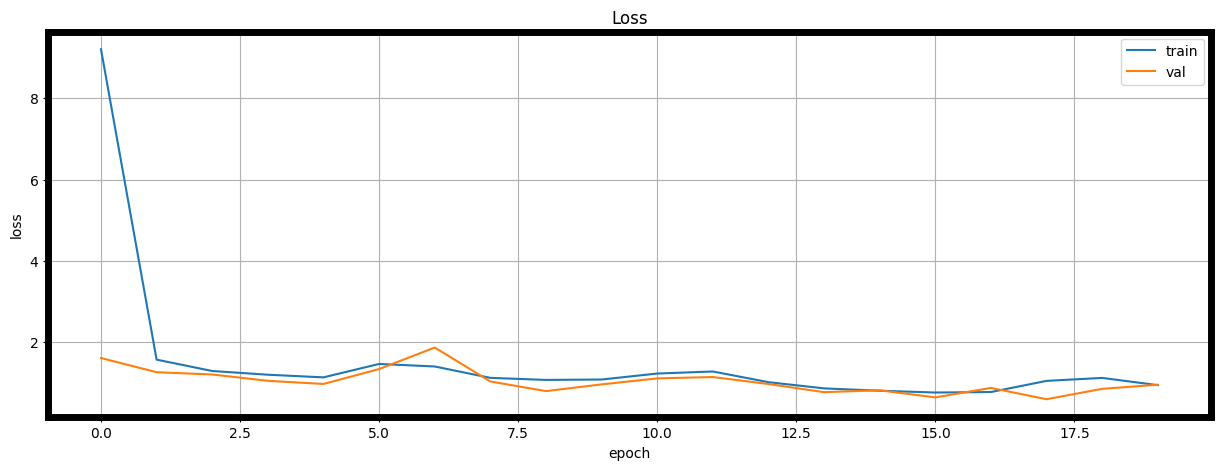

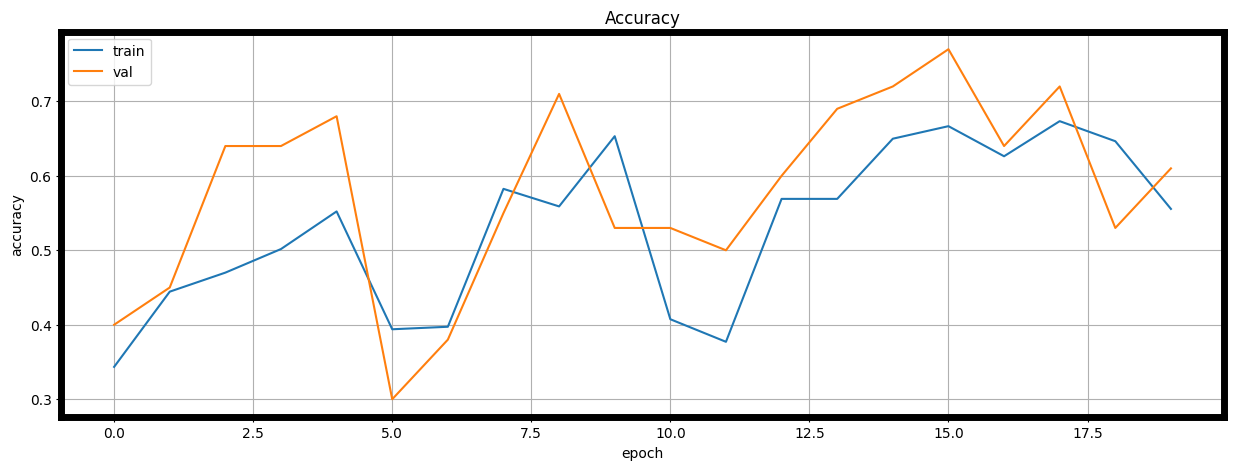

In [69]:

# log metrics to wandb
acct = history.history['acc']
losst = history.history['loss']
accv = history.history['val_acc']
lossv = history.history['val_loss']
for i in range(ep):
    at = acct[i]
    lt = losst[i]
    av = accv[i]
    lv = lossv[i]
    #wandb.log({"Train acc": at, "Train loss": lt})
    #wandb.log({"Val acc": av, "Val loss": lv})

print(f"Train acc : {sum(acct)/len(acct)*100:,.4f}%,Train loss : {(sum(losst)/len(losst)):,.4f}%")
print(f"Val acc : {sum(accv)/len(accv)*100:,.4f}%,Val loss : {(sum(lossv)/len(lossv)):,.4f}%")

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# 6. Evaluate the model on test set

In [70]:
# Evaluate the trained model on the test set
results = model.evaluate(xx_batch_v, yy_batch_v, batch_size=5)
print( f"{model.metrics_names}: {results}" )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - acc: 0.4000 - loss: 1.0467
['loss', 'compile_metrics']: [1.0466941595077515, 0.4000000059604645]


# 7. Inference

In [71]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame(ax, true_label, pred_label):
    if true_label == pred_label:
        color = 'green'
    else:
        color = 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5)

samples.shape=(5, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


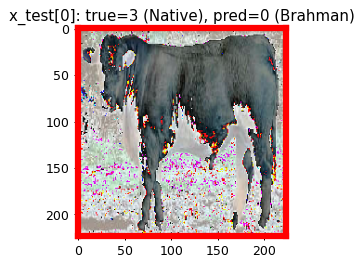

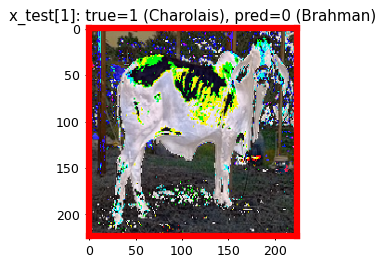

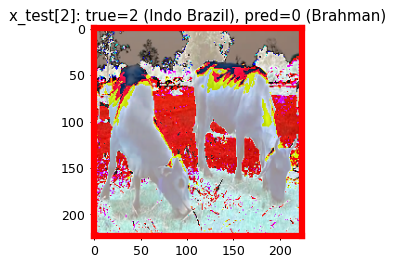

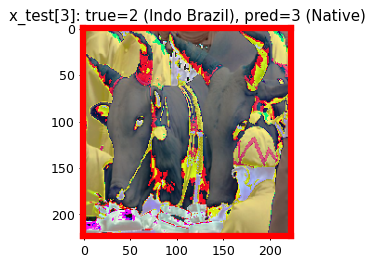

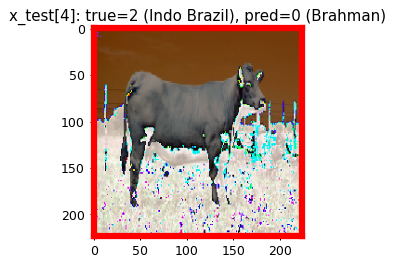

In [74]:
# Test using the model on many images

# Get a batch of samples
n = 5
samples = xx_batch_v[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca() 
    plt.imshow(samples[i].astype(np.uint8))
    true_label = int(np.argmax(y_batch[i]))
    pred_label = int(np.argmax(y_pred[i]))
    plt.title(f"x_test[{i}]: true={true_label} ({labels[true_label]}), pred={pred_label} ({labels[pred_label]})")
    color_frame(ax, true_label, pred_label)
    plt.show()

Grad Cam

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
last_conv_layer_name = "conv5_block3_3_conv"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use the "jet" colormap to colourize the heatmap
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    

    # Resize the heatmap to match the image dimensions
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img) 
    display(Image(plt.imshow(superimposed_img)[0]))
    
    
    #plt.imshow(superimposed_img)
    


for i in range(5):
  c= np.random.randint(0,16)
  img_path = xx_batch_v[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  plt.title(f"Actual = {labels[true_label]}, Pred={pred_label} {labels[pred_label]}")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  display_gradcam(img_path, heatmap)

In [ ]:
wandb.finish()